In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.10.0 True


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Mar_21_19:24:09_Pacific_Daylight_Time_2021
Cuda compilation tools, release 11.3, V11.3.58
Build cuda_11.3.r11.3/compiler.29745058_0


In [2]:
# Just interference

from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import tqdm

In [3]:
# Register dataset
from detectron2.data.datasets import register_coco_instances

# train, val sesuai nama file JSON nya ya
for d in ["train", "val"]:      
    register_coco_instances(f"Components_{d}", {}, f"../custom-datasets/Skenario2/{d}.json", f"../custom-datasets/Skenario2/{d}")


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



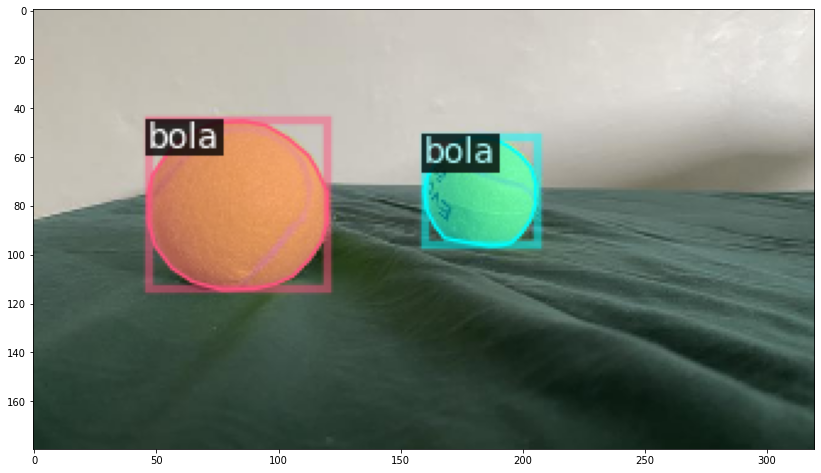

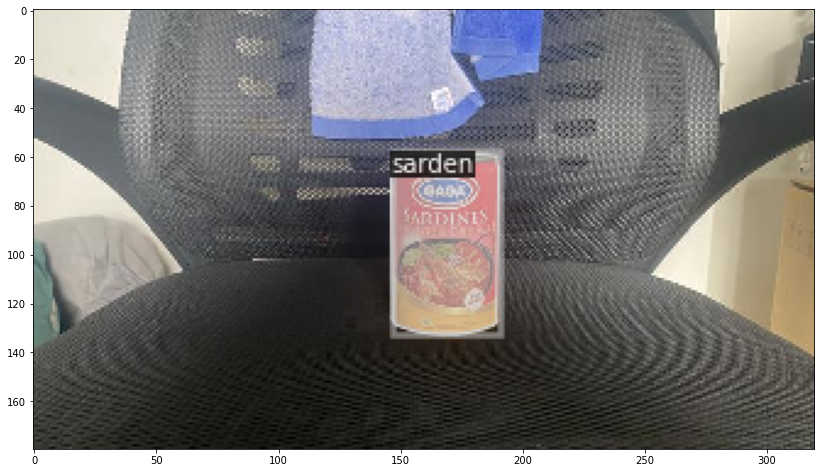

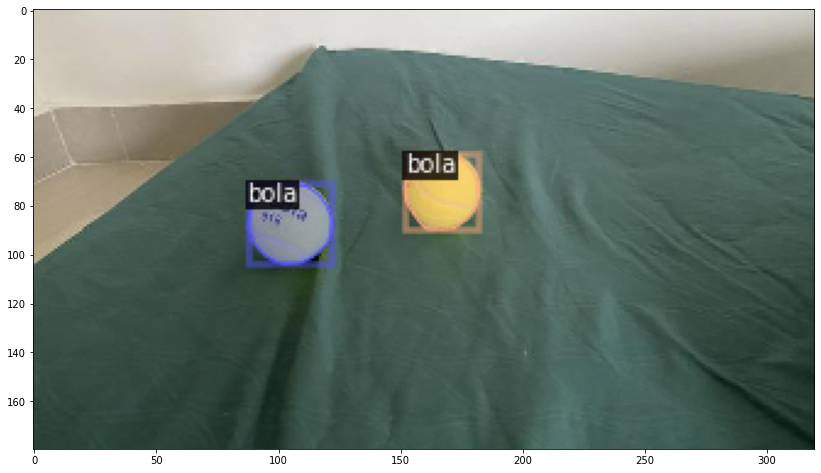

In [4]:
import random
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_dicts = DatasetCatalog.get("Components_train")
test_metadata = MetadataCatalog.get("Components_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=test_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [5]:
# Config

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "trained_model\model_final_ske2.pth"
cfg.DATASETS.TEST = ("Components_val", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 # Jumlah classes

predictor, cfg = DefaultPredictor(cfg), cfg
cpu_device = torch.device("cpu")
test_metadata.get("thing_classes")

['bola', 'kerucut', 'sarden']

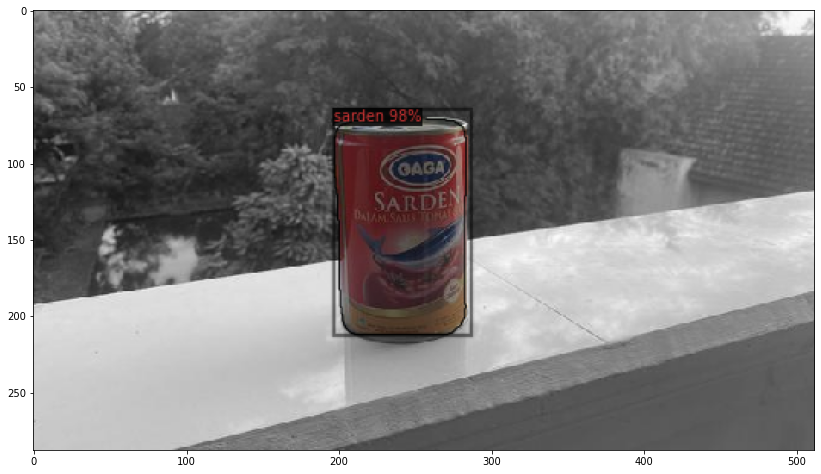

[0.9818345]



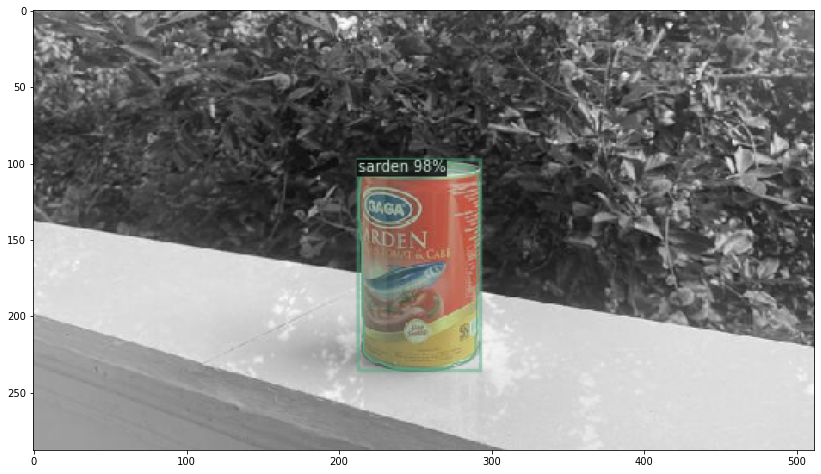

[0.9772588]



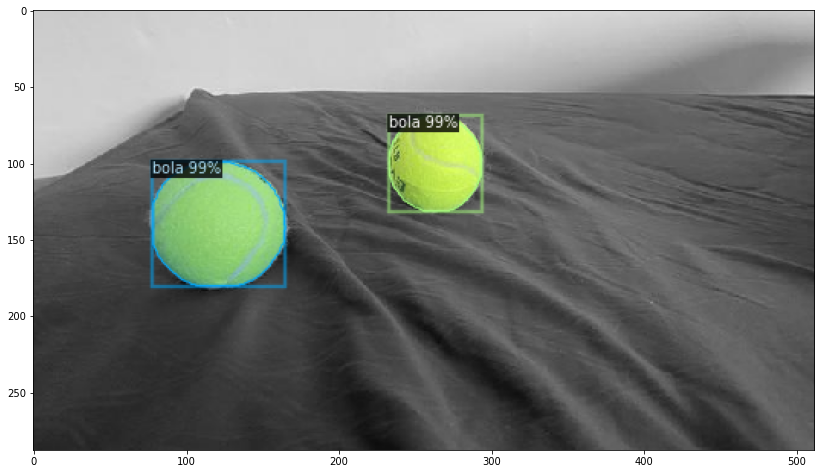

[0.992547   0.98724097]



In [12]:
from detectron2.utils.visualizer import ColorMode

multiple_object = "multipleobject.jpg"

for d in random.sample(dataset_dicts, 3):  
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()
    instances_classes = instances_label = outputs['instances'].scores.to("cpu").numpy()
    print (instances_classes)
    print ("")
    
    
    
    # instances_pred_boxes2 = outputs['instances'].pred_boxes
# instances_pred_boxes = outputs['instances'].pred_boxes.tensor.cpu().numpy()
# instances_classes = outputs['instances'].pred_classes
# instances_label = outputs['instances'].pred_classes.to("cpu").numpy()
# instances_mask = outputs['instances'].pred_masks.to("cpu").numpy()
# x_dist = instances_pred_boxes[:, 2] - instances_pred_boxes[:, 0]
# y_dist = instances_pred_boxes[:, 3] - instances_pred_boxes[:, 1]

In [ ]:
from collections import OrderedDict, Counter
from typing import Tuple, Optional
import numpy as np
from scipy.spatial.distance import cdist

Kerucut_LABEL = 1
Bola_LABEL = 0
Sarden_LABEL = 2

def add_z_coordinate(centers):
    # type: (np.ndarray) -> np.ndarray
    """
    Adds a dummy 0. z-coordinate to the object centers.
    Could be replaced with some depth estimation algorithm in the future.
    Args:
        centers: 2d coordinates for the observed bounding box centers, shape [num_centers, 2]
    :return:
        3d coordinates for the observed bounding box centers, shape [num_centers, 2]
    """
    return np.concatenate((centers, np.zeros(shape=(centers.shape[0], 1))), axis=1)

def compute_center(bounding_boxes):
    x_dist = bounding_boxes[:, 2] - bounding_boxes[:, 0]
    y_dist = bounding_boxes[:, 3] - bounding_boxes[:, 1]
    centers = bounding_boxes[:, 0:2] + 0.5 * np.stack((x_dist, y_dist), axis=1)
    centers_3d = add_z_coordinate(centers)

#     print (x_dist)
#     print (y_dist)
#     print (centers)
#     print (centers_3d)
    return centers_3d

def split_bag_persons(centers, labels):
    # type: (np.ndarray, np.ndarray) -> Tuple[np.ndarray, np.ndarray]
    """
    Splits the centers array based on the label for each center. Labels considered are BAG_LABEL and PERSON_LABEL
    Args:
        centers: Array with bounding box centers, shape [num_centers, ...]
        labels: Array with bounding box labes, shape [num_centers]
    Returns:
        bag_bounding_centers: centers for the bags
        persons_bounding_centers: centers for the persons
    """
    assert isinstance(labels, np.ndarray)
    assert isinstance(centers, np.ndarray)
    print(labels)
    bola_boundCen = centers[labels == Bola_LABEL]
    kerucut_boundCen = centers[labels == Kerucut_LABEL]
    sarden_boundCen = centers[labels == Sarden_LABEL]

    return bola_boundCen, kerucut_boundCen, sarden_boundCen

center = compute_center(instances_pred_boxes)
bola_boundCen, kerucut_boundCen, sarden_boundCen = split_bag_persons(center, instances_label)
print (bola_boundCen)

In [ ]:
class SimpleTracker:
    """
    Location based tracker for persons and bags.
    Also does location based bag-person association.
    """
    
    def __init__(self, self_association_thres, bag_person_thres):
        # type: (float, float) -> None
        """
        Initialize tracker.
        Args:
            self_association_thres: threshold value for person-person and bag-bag association between frames in pixel
                units.
            bag_person_thres: threshold value for initial bag-person association.
        """
        self.all_centers = {'bola': OrderedDict(),
                            'kerucut': OrderedDict(),
                            'sarden': OrderedDict()}  # Stores seen bounding box centers by object id
        self.prev_frame_ids = {'bola': [],
                                'kerucut': [],
                                'sarden': []}  # Stores ids of objects observed in the last frame

        self.bag_person_association = dict()  # Maps bag id to bag owner id
        self.bag_person_dist = dict()  # Maps bag id to distance to the bag owner
        self.instance_count = {'bola': 0,
                                'kerucut': 0,
                                'sarden': 0}  # Counts how many bags and persons have been seen
        self.bag_person_thres = bag_person_thres
        self.self_association_thres = self_association_thres
        self.prev_frame_kept = {'bola': False,
                                'kerucut': False,
                                'sarden': False}  # Tracks if last frame's bounding boxes were kept or ignored
        self.keep_frame_counter = {'bola': 0,
                                    'kerucut': 0,
                                    'sarden: 0'}  # Counts how many frames back object centers have been stored
    
    def update(self, boxes, labels):
        # type: (np.ndarray, np.ndarray) -> None
        """
        Updates the trackers state given bounding box and class detections.
        Args:
            boxes: numpy array containing two diagonal corner coordinates of the bounding boxes,
                shape [num_bounding_boxes, 4]
            labels: Array with bounding box labes, shape [num_centers]
        """
        centers = compute_center(boxes)
        bola_boundCen, kerucut_boundCen, sarden_boundCen = split_bag_persons(centers, labels)

        self.frame2frame_association(bola_boundCen, 'bola')
        self.frame2frame_association(kerucut_boundCen, 'kerucut')
        self.frame2frame_association(sarden_boundCen, 'sarden')
        self.update_bag_person_association()

        print(self.prev_frame_ids)
    
    def frame2frame_association(self, new_centers, tag):
        # type: (np.ndarray, str) -> None
        """
        Associates centers of 'persons' and 'bags' observed in the last frame with centers observed in the current
        frame.
        The association is done forward in time, i.e. we find the closest center in the new frame for each center
        observed in the previous frame.
        If two centers in the previous frame map to the same center in the new frame the closest center gets the
        association.
        In case some center in the new frame can't find a match in the old frame it is added as a new object with a
        new id.
        In case there were no observed objects in the previous frame or no observed objects in the current frame, the
        state is not updated.
        Args:
            new_centers: Array of bounding box centers detected in the current frame.
            tag: Either 'persons' or 'bags'.
        """
        frame_ids = []
        frame_centers = []
        new_frame_unused_centers = list(range(new_centers.shape[0]))
        if len(self.prev_frame_ids[tag]) > 0 and len(new_centers) > 0:
            prev_frame_centers = np.stack([self.all_centers[tag][id] for id in self.prev_frame_ids[tag]], axis=0)
            distances = cdist(prev_frame_centers, new_centers)

            cc_in_new_frame_index = distances.argmin(axis=1)
            new_frame_unused_centers = list(set(new_frame_unused_centers) - set(cc_in_new_frame_index.tolist()))

            min_dist = distances[range(len(self.prev_frame_ids[tag])), cc_in_new_frame_index]
            index_counter = Counter(cc_in_new_frame_index)

            for dist, prev_frame_id, new_center, index in zip(min_dist,
                                                                self.prev_frame_ids[tag],
                                                                new_centers[cc_in_new_frame_index],
                                                                cc_in_new_frame_index):

                if dist < self.self_association_thres and index_counter[index] <= 1:
                    # case where there is a unique closest center
                    self.all_centers[tag][prev_frame_id] = new_center
                    frame_ids.append(prev_frame_id)
                    frame_centers.append(new_center)
                elif dist > self.self_association_thres and index_counter[index] <= 1:
                    # case where the closest frame is too far away
                    self.all_centers[tag][self.instance_count[tag]] = new_center
                    frame_ids.append(self.instance_count[tag])
                    frame_centers.append(new_center)
                    self.instance_count[tag] += 1
                else:
                    # case where one new center is closest to several centers
                    other_dists = min_dist[cc_in_new_frame_index == index]
                    if dist <= other_dists.min():
                        self.all_centers[tag][prev_frame_id] = new_center
                        frame_ids.append(prev_frame_id)
                        frame_centers.append(new_center)

        # add the new centers which were not closest to any old center
        for new_center in new_centers[new_frame_unused_centers, :]:
            self.all_centers[tag][self.instance_count[tag]] = new_center
            frame_ids.append(self.instance_count[tag])
            frame_centers.append(new_center)
            self.instance_count[tag] += 1

        if frame_ids:
            self.prev_frame_ids[tag] = frame_ids
            self.prev_frame_kept[tag] = False
            self.keep_frame_counter[tag] = 0
        else:
            self.keep_frame_counter[tag] += 1
            if self.keep_frame_counter[tag] > 8:
                for id in self.prev_frame_ids[tag]:
                    self.all_centers[tag][id] = np.array([np.Inf, np.Inf, np.Inf])
                self.prev_frame_ids[tag] = []
                self.prev_frame_kept[tag] = False
            else:
                self.prev_frame_kept[tag] = True

In [ ]:
def draw_instance_predictions(visualizer, frame, predictions, tracker):
    """
    Draw instance-level prediction results on an image.

    Args:
        frame (ndarray): an RGB image of shape (H, W, C), in the range [0, 255].
        predictions (Instances): the output of an instance detection/segmentation
            model. Following fields will be used to draw:
            "pred_boxes", "pred_classes", "scores", "pred_masks" (or "pred_masks_rle").

    Returns:
        output (VisImage): image object with visualizations.
    """
    frame_visualizer = Visualizer(frame, visualizer.metadata)
    num_instances = len(predictions)
    if num_instances == 0:
        return frame_visualizer.output
    
    boxes = predictions.pred_boxes.tensor.numpy() if predictions.has("pred_boxes") else None
    scores = predictions.scores if predictions.has("scores") else None
    classes = predictions.pred_classes.numpy() if predictions.has("pred_classes") else None
    keypoints = predictions.pred_keypoints if predictions.has("pred_keypoints") else None

    if predictions.has("pred_masks"):
        masks = predictions.pred_masks
        # mask IOU is not yet enabled
        # masks_rles = mask_util.encode(np.asarray(masks.permute(1, 2, 0), order="F"))
        # assert len(masks_rles) == num_instances
    else:
        masks = None

    detected = [
        detectron2.utils.video_visualizer._DetectedInstance(classes[i], boxes[i], mask_rle=None, color=None, ttl=8)
        for i in range(num_instances)
    ]
    colors = visualizer._assign_colors(detected)

    labels = detectron2.utils.video_visualizer._create_text_labels(classes, scores,
                                                                   visualizer.metadata.get("thing_classes", None))

    if visualizer._instance_mode == ColorMode.IMAGE_BW:
        # any() returns uint8 tensor
        frame_visualizer.output.img = frame_visualizer._create_grayscale_image(
            (masks.any(dim=0) > 0).numpy() if masks is not None else None
        )
        alpha = 0.3
    else:
        alpha = 0.5

    frame_visualizer.overlay_instances(
        boxes=None if masks is not None else boxes,  # boxes are a bit distracting
        masks=masks,
        labels=labels,
        keypoints=keypoints,
        assigned_colors=colors,
        alpha=alpha,
    )
    
    return frame_visualizer.output

In [ ]:
class VisualizationDemo(object):
    def __init__(self, cfg, instance_mode=ColorMode.IMAGE, parallel=False):
        """
        Args:
            cfg (CfgNode):
            instance_mode (ColorMode):
            parallel (bool): whether to run the model in different processes from visualization.
                Useful since the visualization logic can be slow.
        """
        self.metadata = test_metadata
        self.cpu_device = torch.device("cpu")
        self.instance_mode = instance_mode

        self.parallel = parallel
        self.tracker = SimpleTracker(150, 200)
        if parallel:
            num_gpu = torch.cuda.device_count()
            self.predictor = AsyncPredictor(cfg, num_gpus=num_gpu)
        else:
            self.predictor = DefaultPredictor(cfg)
    
    def _frame_from_video(self, video):
        while video.isOpened():
            success, frame = video.read()
            if success:
                yield frame
            else:
                break

    def run_on_video(self, video):
        """
        Visualizes predictions on frames of the input video.

        Args:
            video (cv2.VideoCapture): a :class:`VideoCapture` object, whose source can be
                either a webcam or a video file.

        Yields:
            ndarray: BGR visualizations of each video frame.
        """
        video_visualizer = VideoVisualizer(self.metadata, self.instance_mode)

        def process_predictions(frame, predictions, tracker):
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            if "panoptic_seg" in predictions:
                panoptic_seg, segments_info = predictions["panoptic_seg"]
                vis_frame = video_visualizer.draw_panoptic_seg_predictions(
                    frame, panoptic_seg.to(self.cpu_device), segments_info
                )
            elif "instances" in predictions:
                predictions = predictions["instances"].to(self.cpu_device)
                tracker.update(boxes=predictions.pred_boxes.tensor.numpy(), labels=predictions.pred_classes.numpy())

                if SAVE_PREDICTIONS:
                    SAVED_PREDICTIONS.append(predictions)
                    if len(SAVED_PREDICTIONS) == 100:
                        with open('predictions.pkl', 'wb') as fp:
                            pickle.dump(SAVED_PREDICTIONS, fp)
                            print('Saving done!')

                vis_frame = draw_instance_predictions(video_visualizer, frame, predictions, tracker)

            elif "sem_seg" in predictions:
                vis_frame = video_visualizer.draw_sem_seg(
                    frame, predictions["sem_seg"].argmax(dim=0).to(self.cpu_device)
                )

            # Converts Matplotlib RGB format to OpenCV BGR format
            vis_frame = cv2.cvtColor(vis_frame.get_image(), cv2.COLOR_RGB2BGR)
            return vis_frame

        frame_gen = self._frame_from_video(video)
        if self.parallel:
            buffer_size = self.predictor.default_buffer_size

            frame_data = deque()

            for cnt, frame in enumerate(frame_gen):
                frame_data.append(frame)
                self.predictor.put(frame)

                if cnt >= buffer_size:
                    frame = frame_data.popleft()
                    predictions = self.predictor.get()
                    yield process_predictions(frame, predictions, self.tracker)

            while len(frame_data):
                frame = frame_data.popleft()
                predictions = self.predictor.get()
                yield process_predictions(frame, predictions, self.tracker)
        else:
            for frame in frame_gen:
                yield process_predictions(frame, self.predictor(frame), self.tracker)


class AsyncPredictor:
    """
    A predictor that runs the model asynchronously, possibly on >1 GPUs.
    Because rendering the visualization takes considerably amount of time,
    this helps improve throughput when rendering videos.
    """

    class _StopToken:
        pass

    class _PredictWorker(mp.Process):
        def __init__(self, cfg, task_queue, result_queue):
            self.cfg = cfg
            self.task_queue = task_queue
            self.result_queue = result_queue
            super().__init__()

        def run(self):
            predictor = DefaultPredictor(self.cfg)

            while True:
                task = self.task_queue.get()
                if isinstance(task, AsyncPredictor._StopToken):
                    break
                idx, data = task
                result = predictor(data)
                self.result_queue.put((idx, result))

    def __init__(self, cfg, num_gpus: int = 1):
        """
        Args:
            cfg (CfgNode):
            num_gpus (int): if 0, will run on CPU
        """
        num_workers = max(num_gpus, 1)
        self.task_queue = mp.Queue(maxsize=num_workers * 3)
        self.result_queue = mp.Queue(maxsize=num_workers * 3)
        self.procs = []
        for gpuid in range(max(num_gpus, 1)):
            cfg = cfg.clone()
            cfg.defrost()
            cfg.MODEL.DEVICE = "cuda:{}".format(gpuid) if num_gpus > 0 else "cpu"
            self.procs.append(
                AsyncPredictor._PredictWorker(cfg, self.task_queue, self.result_queue)
            )

        self.put_idx = 0
        self.get_idx = 0
        self.result_rank = []
        self.result_data = []

        for p in self.procs:
            p.start()
        atexit.register(self.shutdown)

    def put(self, image):
        self.put_idx += 1
        self.task_queue.put((self.put_idx, image))

    def get(self):
        self.get_idx += 1  # the index needed for this request
        if len(self.result_rank) and self.result_rank[0] == self.get_idx:
            res = self.result_data[0]
            del self.result_data[0], self.result_rank[0]
            return res

        while True:
            # make sure the results are returned in the correct order
            idx, res = self.result_queue.get()
            if idx == self.get_idx:
                return res
            insert = bisect.bisect(self.result_rank, idx)
            self.result_rank.insert(insert, idx)
            self.result_data.insert(insert, res)

    def __len__(self):
        return self.put_idx - self.get_idx

    def __call__(self, image):
        self.put(image)
        return self.get()

    def shutdown(self):
        for _ in self.procs:
            self.task_queue.put(AsyncPredictor._StopToken())

    @property
    def default_buffer_size(self):
        return len(self.procs) * 5

In [ ]:
demo = VisualizationDemo(cfg)

# cam = cv2.VideoCapture(args.webcam)
cam = cv2.VidepCapture("http://Cartensz-Pc.local:8000")
for vis in tqdm.tqdm(demo.run_on_video(cam)):
    cv2.namedWindow(WINDOW_NAME, cv2.WINDOW_NORMAL)
    cv2.imshow(WINDOW_NAME, vis)
    if cv2.waitKey(1) == 27:
        break  # esc to quit
cv2.destroyAllWindows()